# Example for stock price models

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..') 

import price_models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

### We will define two price models: 

In [2]:
gbm = price_models.GBMModel() # Define geometrical Brownian motion model


data = pd.read_csv("SPY_close_price.csv") # Upload data
data = data["Close"]
changes = np.diff(data)/data[:-1].to_numpy() # Construct the relative change of the price in %
changes -= changes.mean() # cented at 0
emp = price_models.EmpiricalReturnModel(data, period="day") # Define model based on historical data

Interpolating probability distribution function...
Interpolation finished.


### We can calculate the the probability density functions

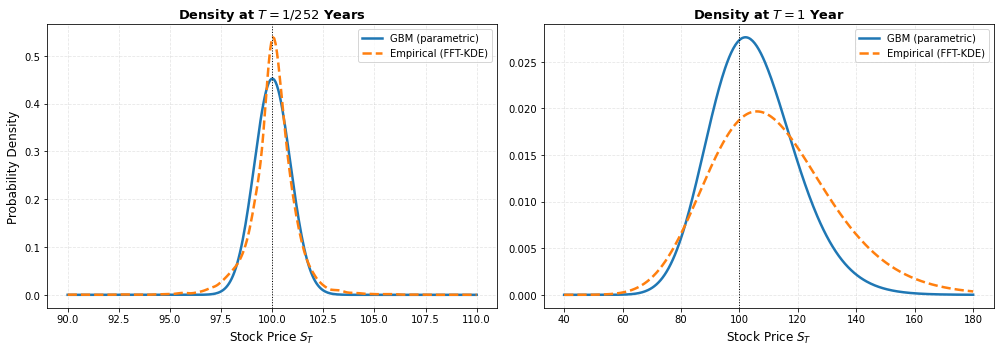

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
S0 = 100  # Spot price
T1, T2 = 1/252, 1  # Horizons
vol, r = 0.14, 0.05  # GBM parameters

# Price grids
ST1 = np.linspace(90, 110, 300)
ST2 = np.linspace(40, 180, 400)

# Compute PDFs
pdf_gbm_T1 = gbm.stock_pdf(S0, ST1, T1, vol, r)
pdf_emp_T1 = emp.stock_pdf(S0, ST1, T1)
pdf_gbm_T2 = gbm.stock_pdf(S0, ST2, T2, vol, r)
pdf_emp_T2 = emp.stock_pdf(S0, ST2, T2)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Left: short horizon ---
axes[0].plot(ST1, pdf_gbm_T1, label="GBM (parametric)", color="tab:blue", linewidth=2.5)
axes[0].plot(ST1, pdf_emp_T1, label="Empirical (FFT-KDE)", color="tab:orange", linestyle="--", linewidth=2.5)
axes[0].axvline(S0, color="black", linestyle=":", linewidth=1)
axes[0].set_title("Density at $T = 1/252$ Years", fontsize=13, weight="bold")
axes[0].set_xlabel("Stock Price $S_T$", fontsize=12)
axes[0].set_ylabel("Probability Density", fontsize=12)
axes[0].grid(alpha=0.3, linestyle="--")
axes[0].legend(fontsize=10)

# --- Right: longer horizon ---
axes[1].plot(ST2, pdf_gbm_T2, label="GBM (parametric)", color="tab:blue", linewidth=2.5)
axes[1].plot(ST2, pdf_emp_T2, label="Empirical (FFT-KDE)", color="tab:orange", linestyle="--", linewidth=2.5)
axes[1].axvline(S0, color="black", linestyle=":", linewidth=1)
axes[1].set_title("Density at $T = 1$ Year", fontsize=13, weight="bold")
axes[1].set_xlabel("Stock Price $S_T$", fontsize=12)
axes[1].grid(alpha=0.3, linestyle="--")
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()


### And compute the means, standard deviation, variance...

In [4]:
print(f"For T1 = {T1}:")
print(f"Mean {gbm.pdf_mean(S0, T1, vol, r)}. Std: {gbm.pdf_std(S0, T1, vol, r)}")
print(f"Mean {emp.pdf_mean(S0, T1)}. Std: {emp.pdf_std(S0, T1)}")
print(f"For T1 = {T2}:")
print(f"Mean {gbm.pdf_mean(S0, T2, vol, r)}. Std: {gbm.pdf_std(S0, T2, vol, r)}")
print(f"Mean {emp.pdf_mean(S0, T2)}. Std: {emp.pdf_std(S0, T2)}")

For T1 = 0.003968253968253968:
Mean 100.01886149840931. Std: 0.9354900403741466


/home/alan/AZ/Finance/price_models/examples/../../price_models/stock_price_models/stock_price_model.py:71: RuntimeWarning: Integration range [0.1, 10000.0] is very wide relative to S0=100. Falling back to trapezoidal integration.
  warnings.warn(


Mean 100.04675684224543. Std: 1.189317573939841
For T1 = 1:
Mean 105.12496436421225. Std: 14.791345899888285
Mean 111.49486941166774. Std: 21.225796680185965


In [5]:
emp.prob_between(100, 0.001, 10000, T1)

/home/alan/AZ/Finance/price_models/examples/../../price_models/stock_price_models/stock_price_model.py:71: RuntimeWarning: Integration range [0.001, 10000] is very wide relative to S0=100. Falling back to trapezoidal integration.
  warnings.warn(


0.9999999897991605

### We can compute the probability for the stock price to be in a specific interval `(ST1, ST2)` at the horizons `T1` and `T2`

In [6]:
ST1 = 99
ST2 = 101
print(f"Probability between ST1 = {ST1} and ST2 = {ST2}:")
print(f"For GBM: p1 = {gbm.prob_between(S0, ST1, ST2, T1, vol, r):.3f}, p2 =  {gbm.prob_between(S0, ST1, ST2, T2, vol, r):.3f}")
print(f"For Empirical: p1 = {emp.prob_between(S0, ST1, ST2, T1):.3f}, p2 =  {emp.prob_between(S0, ST1, ST2, T2):.3f}")

Probability between ST1 = 99 and ST2 = 101:
For GBM: p1 = 0.743, p2 =  0.055
For Empirical: p1 = 0.724, p2 =  0.038


### We can change the question and ask what is the price interval (around the spot price `S0`) that includes a mass probability of `coverage_prob`

In [7]:
T = 1
coverage_prob = 0.68
print(f"GBM: {gbm.price_interval(S0, T, coverage_prob, vol, r)}")
print(f"Empirical: {emp.price_interval(S0, T, coverage_prob)}")

GBM: (85.28021215154315, 114.77510763165222)
Empirical: (78.06479714500817, 122.06243579852175)


### We can simulate paths according to our models, which also allows us to make many Monte Carlo simulations

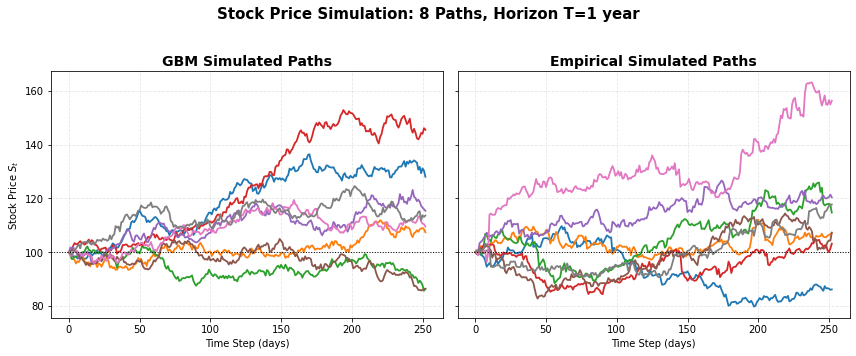

In [10]:
# Parameters
S0 = 100
N_paths = 8
N_steps = 252
time_arr = np.arange(0, N_steps + 1)
T = 1
vol, r = 0.14, 0.0

# Simulate
gbm_paths = gbm.simulate_paths(S0, T, vol, r, N_steps=N_steps, N_paths=N_paths)
emp_paths = emp.simulate_paths(S0, T, N_paths=N_paths)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- GBM ---
for i in range(N_paths):
    axes[0].plot(time_arr, gbm_paths[i], lw=1.8)
axes[0].axhline(S0, color="black", linestyle=":", lw=1)
axes[0].set_title("GBM Simulated Paths", fontsize=14, weight="bold")
axes[0].set_xlabel("Time Step (days)")
axes[0].set_ylabel("Stock Price $S_t$")
axes[0].grid(alpha=0.3, linestyle="--")

# --- Empirical ---
for i in range(N_paths):
    axes[1].plot(time_arr, emp_paths[i], lw=1.8)
axes[1].axhline(S0, color="black", linestyle=":", lw=1)
axes[1].set_title("Empirical Simulated Paths", fontsize=14, weight="bold")
axes[1].set_xlabel("Time Step (days)")
axes[1].grid(alpha=0.3, linestyle="--")

plt.suptitle(f"Stock Price Simulation: {N_paths} Paths, Horizon T={T} year", fontsize=15, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### One thing we can do with simulations is estimate the probability of touch (POT) of the stock touching some value `barrier` before the horizon `T`

In [9]:
S0 = 100
barrier = 130
T = 1
N_paths=100_000
gbm.POT(S0, T, barrier, 0.14, r, N_steps=252, N_paths=N_paths), emp.POT(S0, T, barrier, N_paths=N_paths)

(0.0564, 0.29298)